In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings

import joblib

sys.path.append("/app")
from copy import deepcopy
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from tqdm.notebook import tqdm

from conceptual_runs.scripts.data_readers import metric_df, read_gauge
from visualizations.scripts.drawer import russia_plots, russia_plots_n

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


### Read necessary geometry

In [3]:
gauges_file = gpd.read_file("../data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../data/geometry/basin_districts_2024.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# basin_districts = basin_districts.drop([26, 27])
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})


In [4]:
def read_table_gauge_str(
    table_path: str, index_filter: pd.Index = pd.Index([])
) -> tuple[pd.DataFrame, float]:
    table = pd.read_csv(table_path)
    if "Unnamed: 0" in table.columns:
        table = table.rename(columns={"Unnamed: 0": "gauge_id"})
    table["gauge_id"] = table["gauge_id"].astype(str)
    table = table.set_index("gauge_id")

    if index_filter.empty:
        pass
    else:
        table = table.loc[table.index.isin(index_filter)]
    median_nse = table["NSE"].median()
    return table, median_nse

### Use only gauges from LSTM model

In [5]:
hbv_table = pd.read_csv(
    "/app/conclusions/tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

gr4j_table = pd.read_csv(
    "/app/conclusions/tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "/app/conclusions/tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_regional = pd.read_csv(
    "/app/conclusions/tables/cudalstm_q_mm_day_mswep_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_single = pd.read_csv(
    "/app/conclusions/tables/Single_LSTM_table.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_no_static = pd.read_csv(
    "/app/conclusions/tables/LSTM_no_static_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_regional.index)
    .intersection(ws_file.index)
    .intersection(gauges_file.index)
    .intersection(lstm_single.index)
    .intersection(lstm_no_static.index)
)


ws_file = ws_file.loc[common_index, :]
gauges_file = gauges_file.loc[common_index, :]
gauges_file["size"] = np.nan
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)

### HBV and GR4J

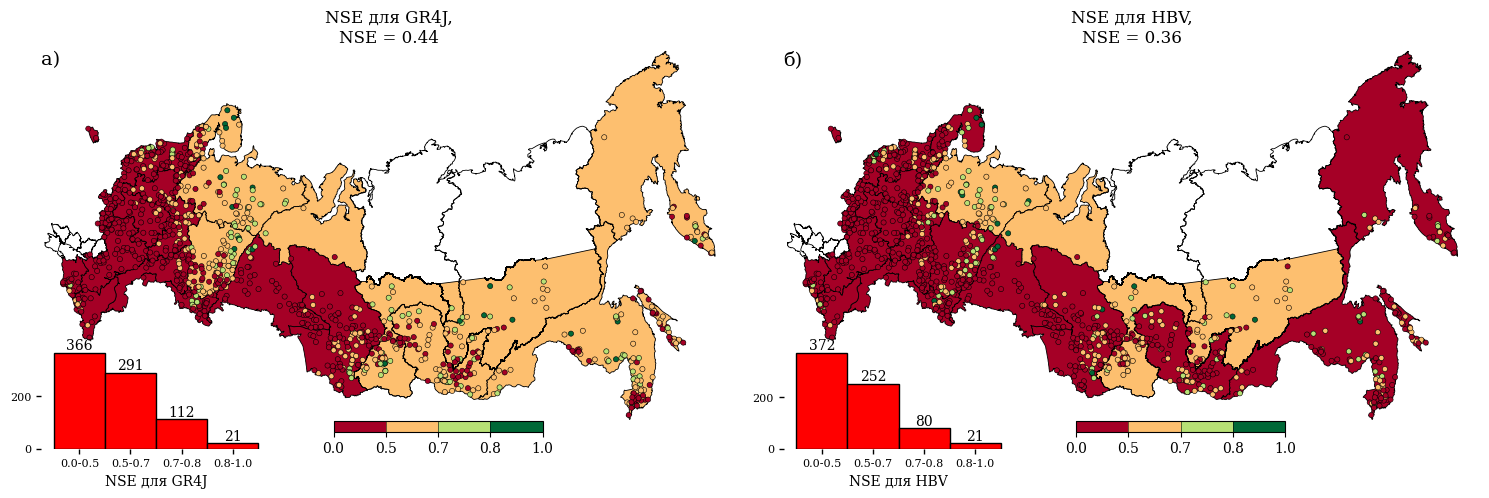

In [6]:
hbv_table, nse_hbv = read_table_gauge_str(
    table_path="/app/conclusions/tables/HBV_res_mle_NSE.csv", index_filter=common_index
)
gr4j_table, nse_gr4j = read_table_gauge_str(
    table_path="/app/conclusions/tables/GR4J_res_mle_NSE.csv", index_filter=common_index
)

hbv_gr4j_nse = gauges_file.loc[:, ["geometry"]]

hbv_gr4j_nse.loc[:, ["NSE GR4J", "NSE HBV"]] = pd.concat(
    [gr4j_table.loc[common_index, "NSE"], hbv_table.loc[common_index, "NSE"]],
    axis=1,
).values


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = hbv_gr4j_nse.loc[
        [geom.intersects(gage_point) for gage_point in hbv_gr4j_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE GR4J", "NSE HBV"]] = ugms_part[["NSE GR4J", "NSE HBV"]].median()

basin_districts.loc[[26, 27], ["NSE GR4J", "NSE HBV"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=hbv_gr4j_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    columns_from_gdf=["NSE GR4J", "NSE HBV"],
    hist_name=["NSE для GR4J", "NSE для HBV"],
    with_histogram=True,
    title_text=[
        f"NSE для GR4J,\nNSE = {nse_gr4j:.2f}",
        f"NSE для HBV,\nNSE = {nse_hbv:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


In [7]:
basin_districts.loc[:, ["name1", "NSE GR4J", "NSE HBV"]].dropna().to_csv(
    "/app/data/dw_tables/bo_hbv_gr4j.csv", index=False
)
gr4j_hbv = pd.concat([hbv_table.median().to_frame().T, gr4j_table.median().to_frame().T])

gr4j_hbv.index = pd.Index(["HBV", "GR4J"])
gr4j_hbv.index.name = "Модель"
gr4j_hbv.to_excel("/app/data/dw_tables/gr4j_hbv_statistics.xlsx", float_format="%.2f")


### Random forest

#### Calculate files from Random Forest results

In [ ]:
rfr_metric = list()
for gauge_id in tqdm(list(i.stem for i in Path("/app/data/conceptual_models/rfr_cv/").glob("*.joblib"))):
    _, test = read_gauge(gauge_id=gauge_id, simple=True)

    X_test = deepcopy(test)
    for days in (2**n for n in range(6)):
        X_test[[f"prcp_{days}"]] = test[["prcp_e5l"]].rolling(window=days).sum()
        X_test[[f"t_min_mean_{days}"]] = test[["t_min_e5l"]].rolling(window=days).mean()
        X_test[[f"t_max_mean_{days}"]] = test[["t_min_e5l"]].rolling(window=days).mean()
    X_test = X_test.dropna()

    feature_cols = [
        item
        for sublist in [
            [f"{var}_{day}" for day in (2**n for n in range(6))]
            for var in ["prcp", "t_min_mean", "t_max_mean"]  # "t_min_sum", "t_max_sum"]
        ]
        for item in sublist
    ]
    X_test = X_test[feature_cols]
    X_test = X_test.to_numpy()
    # create target
    Y_test = test[["q_mm_day"]]
    Y_test = Y_test.to_numpy().ravel()

    rfr_model = joblib.load(f"/app/data/conceptual_models/rfr_cv/{gauge_id}.joblib")
    # get prediction
    fin_df = test.iloc[31:, [0]]
    fin_df["q_mm_rfr"] = rfr_model.predict(X_test)

    rfr_metric.append(metric_df(gauge_id, predictions=fin_df["q_mm_rfr"], targets=fin_df["q_mm_day"]))
pd.concat(rfr_metric).to_csv("/app/conclusions/tables/res_rfr_cv.csv")


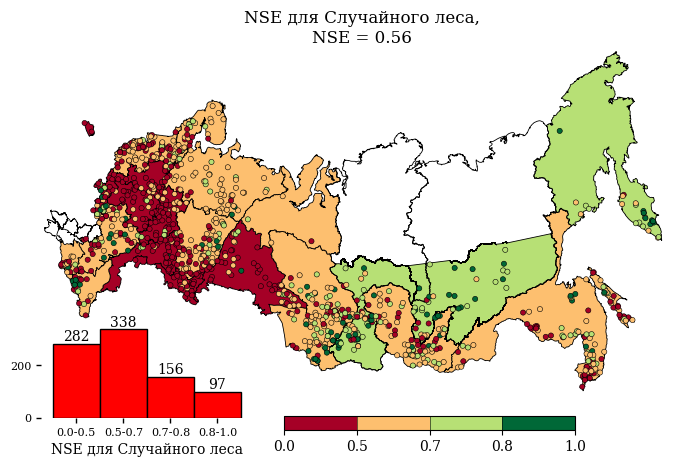

In [8]:
rfr_table, rfr_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/res_rfr_cv.csv", index_filter=common_index
)

rfr_geom_nse = gauges_file.loc[:, ["geometry"]]

rfr_geom_nse.loc[:, ["NSE Случайный лес"]] = pd.concat(
    [rfr_table.loc[common_index, "NSE"]],
    axis=1,
).values


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = rfr_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in rfr_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE Случайный лес"]] = ugms_part[["NSE Случайный лес"]].median()

basin_districts.loc[[26, 27], ["NSE Случайный лес"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=rfr_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE Случайный лес"],
    hist_name=["NSE для Случайного леса"],
    with_histogram=True,
    title_text=[f"NSE для Случайного леса,\nNSE = {rfr_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [9]:
basin_districts.loc[:, ["name1", "NSE Случайный лес"]].dropna().to_csv(
    "/app/data/dw_tables/bo_rfr.csv", index=False
)
rfr = pd.concat([rfr_table.median().to_frame().T])
rfr.index = pd.Index(["Случайный лес"])
rfr.index.name = "Модель"
rfr.to_excel("/app/data/dw_tables/random_forest_statistics.xlsx", float_format="%.2f")


### LSTM-vanila, LSTM-single, LSTM-regional

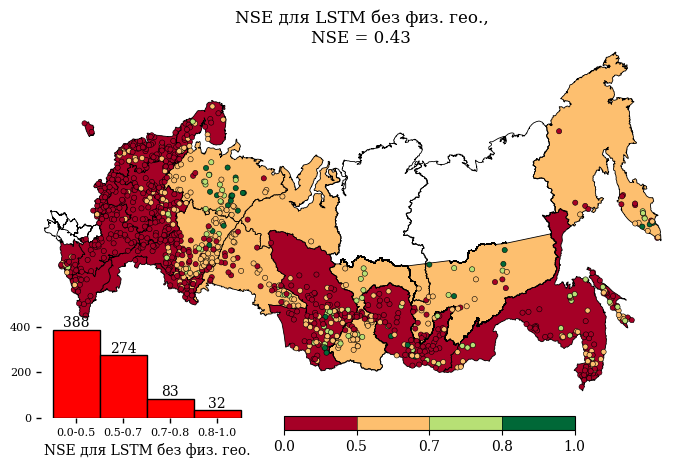

In [10]:
lstm_vanila_table, lstm_vanila_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/LSTM_no_static_res.csv", index_filter=common_index
)

lstm_vanila_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_vanila_geom_nse.loc[:, ["NSE LSTM без физ. гео."]] = pd.concat(
    [lstm_vanila_table.loc[common_index, "NSE"]],
    axis=1,
).values


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_vanila_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_vanila_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM без физ. гео."]] = ugms_part[["NSE LSTM без физ. гео."]].median()

basin_districts.loc[[26, 27], ["NSE LSTM без физ. гео."]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_vanila_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM без физ. гео."],
    hist_name=["NSE для LSTM без физ. гео."],
    with_histogram=True,
    title_text=[f"NSE для LSTM без физ. гео.,\nNSE = {lstm_vanila_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [11]:
basin_districts.loc[:, ["name1", "NSE LSTM без физ. гео."]].dropna().to_csv(
    "/app/data/dw_tables/bo_lstm_no_geo.csv", index=False
)
lstm_vanila_table_stat = pd.concat([lstm_vanila_table.median().to_frame().T])
lstm_vanila_table_stat.index = pd.Index(["NSE LSTM без физ. гео."])
lstm_vanila_table_stat.index.name = "Модель"
lstm_vanila_table_stat.to_excel("/app/data/dw_tables/lstm_no_geo_statistics.xlsx", float_format="%.2f")


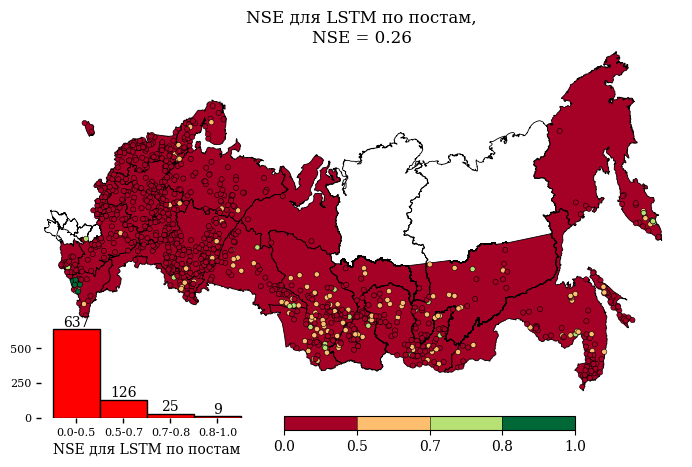

In [12]:
lstm_single_table, lstm_single_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/Single_LSTM_table.csv", index_filter=common_index
)

lstm_single_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_single_geom_nse.loc[:, ["NSE LSTM по постам"]] = pd.concat(
    [lstm_single_table.loc[common_index, "NSE"]],
    axis=1,
).values


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_single_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_single_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM по постам"]] = ugms_part[["NSE LSTM по постам"]].median()

basin_districts.loc[[26, 27], ["NSE LSTM по постам"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_single_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM по постам"],
    hist_name=["NSE для LSTM по постам"],
    with_histogram=True,
    title_text=[f"NSE для LSTM по постам,\nNSE = {lstm_single_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [13]:
basin_districts.loc[:, ["name1", "NSE LSTM по постам"]].dropna().to_csv(
    "/app/data/dw_tables/bo_lstm_no_geo.csv", index=False
)
lstm_single_table_stat = pd.concat([lstm_single_table.median().to_frame().T])
lstm_single_table_stat.index = pd.Index(["NSE LSTM по постам"])
lstm_single_table_stat.index.name = "Модель"
lstm_single_table_stat.to_excel("/app/data/dw_tables/lstm_single_statistics.xlsx", float_format="%.2f")


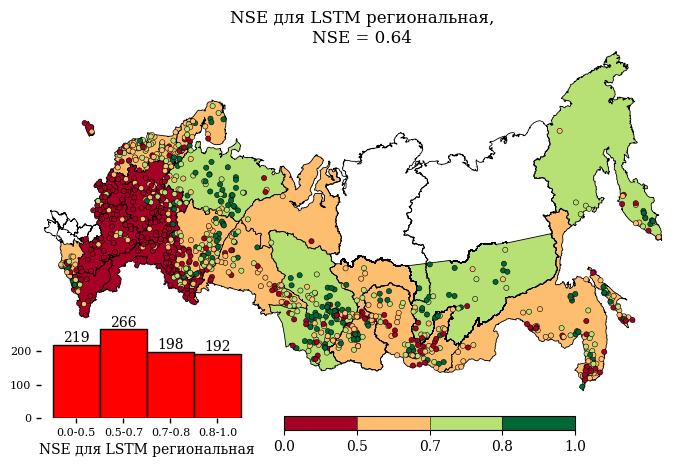

In [14]:
lstm_regional_table, lstm_regional_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_mswep_res.csv", index_filter=common_index
)
common_index = common_index.intersection(lstm_regional_table.index)
lstm_regional_geom_nse = gauges_file.loc[common_index, ["geometry"]]

lstm_regional_geom_nse.loc[:, ["NSE LSTM региональная"]] = pd.concat(
    [lstm_regional_table.loc[common_index, "NSE"]],
    axis=1,
).values


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_regional_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_regional_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM региональная"]] = ugms_part[["NSE LSTM региональная"]].median()

basin_districts.loc[[26, 27], ["NSE LSTM региональная"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_regional_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM региональная"],
    hist_name=["NSE для LSTM региональная"],
    with_histogram=True,
    title_text=[f"NSE для LSTM региональная,\nNSE = {lstm_regional_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [15]:
basin_districts.loc[:, ["name1", "NSE LSTM региональная"]].dropna().to_csv(
    "/app/data/dw_tables/bo_lstm_regional.csv", index=False
)
lstm_regional_table_stat = pd.concat([lstm_regional_table.median().to_frame().T])
lstm_regional_table_stat.index = pd.Index(["NSE LSTM региональная"])
lstm_regional_table_stat.index.name = "Модель"
lstm_regional_table_stat.to_excel(
    "/app/data/dw_tables/lstm_regional_statistics.xlsx", float_format="%.2f"
)


In [16]:
lstm_s = pd.concat(
    [
        lstm_regional_table.median().to_frame().T,
        lstm_single_table.median().to_frame().T,
        lstm_vanila_table.median().to_frame().T,
    ]
)

lstm_s.index = pd.Index(["LSTM региональная", "LSTM по постам", "LSTM без физ. гео."])
lstm_s.index.name = "Модель"
lstm_s.to_csv("/app/data/dw_tables/lstm_s_statistics.csv", float_format="%.2f")


### LSTM-ERA5, LSTM-MSWEP, LSTM-ERA5-Land, LSTM-GPCP

In [144]:
lstm_geom_nse = gauges_file.loc[common_index, ["geometry"]]

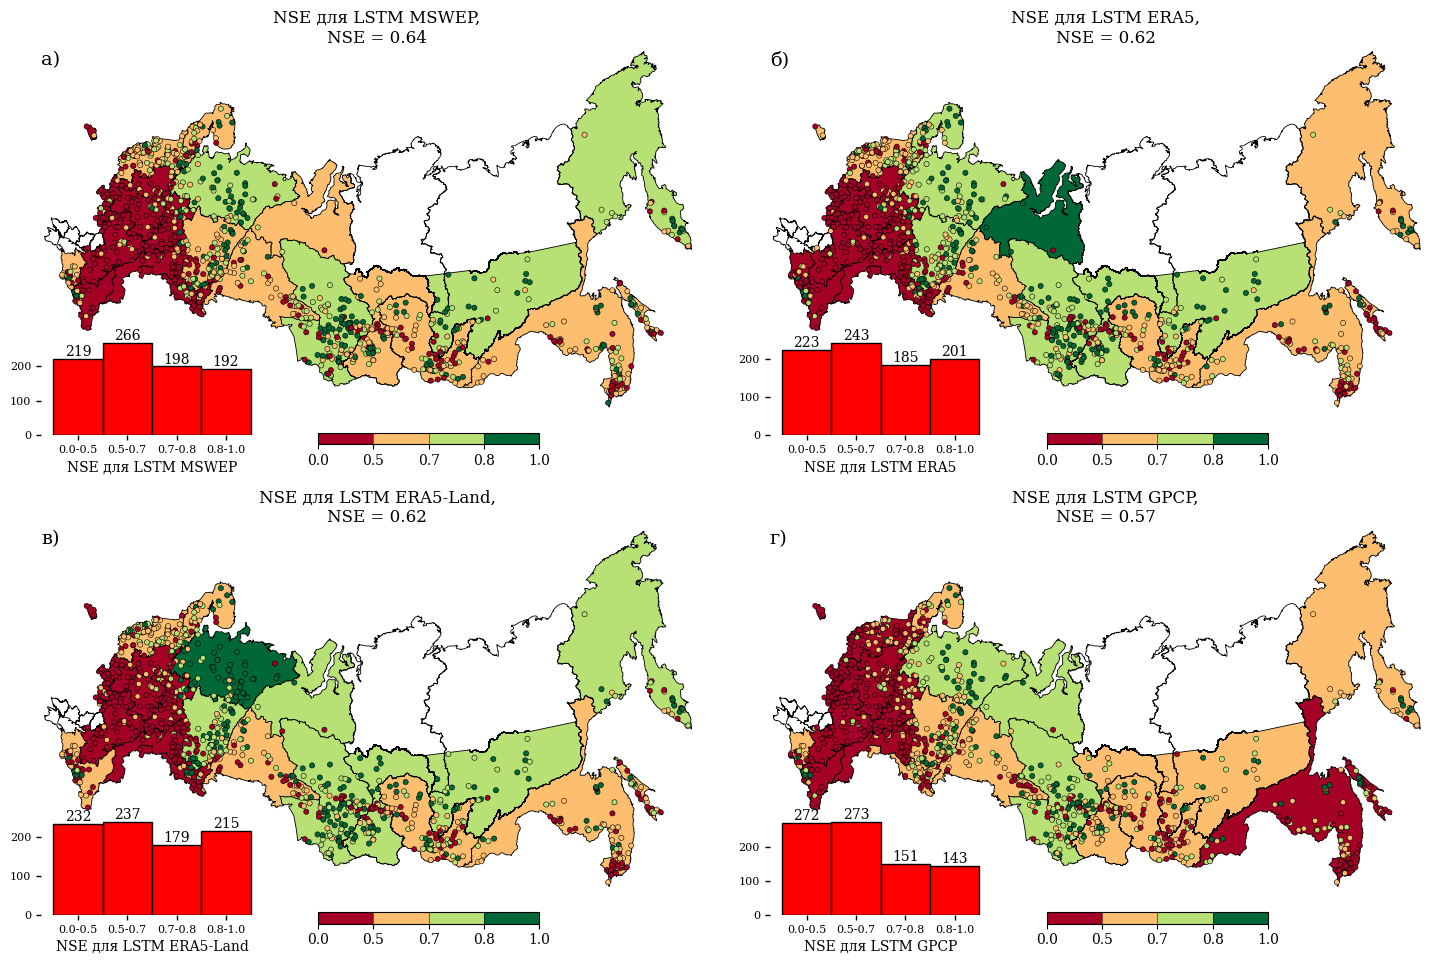

In [145]:
lstm_mswep_table, lstm_mswep_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_mswep_res.csv", index_filter=common_index
)
lstm_era5_table, lstm_era5_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_era5_res.csv", index_filter=common_index
)
lstm_era5_land_table, lstm_era5_land_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_era5l_res.csv", index_filter=common_index
)
lstm_gpcp_table, lstm_gpcp_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_gpcp_res.csv", index_filter=common_index
)
common_index = common_index.intersection(lstm_gpcp_table.index)


lstm_geom_nse.loc[:, ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]] = (
    pd.concat(
        [
            lstm_mswep_table.loc[common_index, "NSE"],
            lstm_era5_table.loc[common_index, "NSE"],
            lstm_era5_land_table.loc[common_index, "NSE"],
            lstm_gpcp_table.loc[common_index, "NSE"],
        ],
        axis=1,
    ).values
)

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[
        i, ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
    ] = ugms_part[["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]].median()

basin_districts.loc[
    [26, 27], ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=2,
    ncols=2,
    label_list=["а)", "б)", "в)", "г)"],
    columns_from_gdf=["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"],
    hist_name=["NSE для LSTM MSWEP", "NSE для LSTM ERA5", "NSE для LSTM ERA5-Land", "NSE для LSTM GPCP"],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM MSWEP,\nNSE = {lstm_mswep_nse:.2f}",
        f"NSE для LSTM ERA5,\nNSE = {lstm_era5_nse:.2f}",
        f"NSE для LSTM ERA5-Land,\nNSE = {lstm_era5_land_nse:.2f}",
        f"NSE для LSTM GPCP,\nNSE = {lstm_gpcp_nse:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [146]:
basin_districts.loc[
    :, ["name1", "NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
].dropna().to_csv("/app/data/dw_tables/bo_lstm_meteo_4.csv", index=False)
lstm_meteo_4_table = pd.concat(
    [
        lstm_mswep_table.loc[common_index, :].median().to_frame().T,
        lstm_era5_table.loc[common_index, :].median().to_frame().T,
        lstm_era5_land_table.loc[common_index, :].median().to_frame().T,
        lstm_gpcp_table.loc[common_index, :].median().to_frame().T,
    ]
)
lstm_meteo_4_table.index = pd.Index(
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
)
lstm_meteo_4_table.index.name = "Модель"
lstm_meteo_4_table.to_excel("/app/data/dw_tables/lstm_meteo_4_statistics.xlsx", float_format="%.2f")


#### Get best NSE for each gauge for each meteo input

In [147]:
lstm_geom_nse["Best Meteo NSE"] = lstm_geom_nse[
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
].max(axis=1)
mswep_index = lstm_geom_nse[lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM MSWEP"])].index
era5_index = lstm_geom_nse[lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM ERA5"])].index
era5_land_index = lstm_geom_nse[
    lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM ERA5-Land"])
].index
gpcp_index = lstm_geom_nse[lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM GPCP"])].index

for name, index in {
    "MSWEP": mswep_index,
    "ERA5": era5_index,
    "ERA5-Land": era5_land_index,
    "GPCP": gpcp_index,
}.items():
    lstm_geom_nse.loc[index, "Лучшая метео модель"] = name


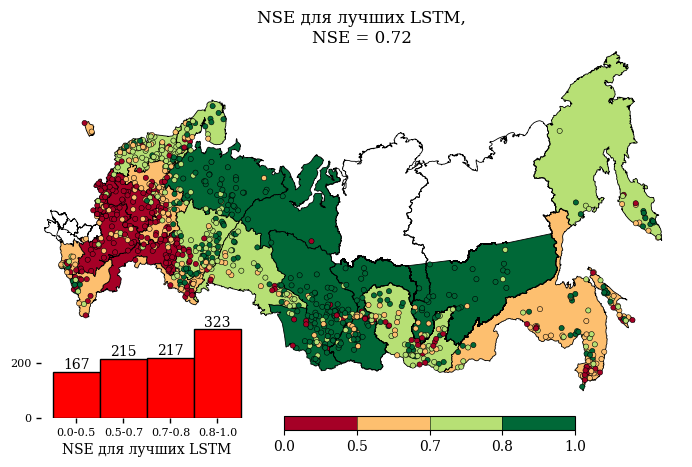

In [148]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["Best Meteo NSE"]] = ugms_part[["Best Meteo NSE"]].median()
    lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], "Бассейновый округ"
    ] = ugms_name

basin_districts.loc[[26, 27], ["Best Meteo NSE"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["Best Meteo NSE"],
    hist_name=["NSE для лучших LSTM"],
    with_histogram=True,
    title_text=[f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['Best Meteo NSE'].median():.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [149]:
lstm_geom_nse


geometry  NSE LSTM MSWEP  NSE LSTM ERA5  \
gauge_id                                                         
70158     POINT (45.634 60.054)        0.833943       0.820407   
8290      POINT (97.383 58.032)        0.847587       0.850689   
70583     POINT (39.273 59.991)        0.525068       0.624427   
76408     POINT (59.675 55.172)        0.542724       0.306889   
72668     POINT (29.146 56.505)        0.757252       0.580494   
...                         ...             ...            ...   
10584     POINT (88.325 55.764)        0.359196       0.263809   
72577     POINT (28.593 59.383)        0.815723       0.742813   
8347      POINT (98.665 55.537)        0.411140       0.463229   
48069       POINT (35.81 62.61)        0.478429       0.711289   
7174       POINT (103.9 51.589)        0.690419       0.642418   

          NSE LSTM ERA5-Land  NSE LSTM GPCP  Best Meteo NSE  \
gauge_id                                                      
70158               0.831432       0.740344        0.833943   
8290                0.871560       0.833061        0.871560   
70583               0.625878       0.439023        0.625878   
76408               0.233973       0.446993        0.542724   
72668               0.641525       0.479778        0.757252   
...                      ...            ...             ...   
10584               0.361511      -0.580998        0.361511   
72577               0.823620       0.620366        0.823620   
8347                0.329005       0.344148        0.463229   
48069               0.708054       0.572330        0.711289   
7174                0.779286       0.695856        0.779286   

         Лучшая метео модель   Бассейновый округ  
gauge_id                                          
70158                  MSWEP   Двинско-Печорский  
8290               ERA5-Land  Ангаро-Байкальский  
70583              ERA5-Land   Двинско-Печорский  
76408                  MSWEP             Камский  
72668                  MSWEP          Балтийский  
...                      ...                 ...  
10584              ERA5-Land        Верхнеобский  
72577              ERA5-Land          Балтийский  
8347                    ERA5  Ангаро-Байкальский  
48069                   ERA5          Балтийский  
7174               ERA5-Land  Ангаро-Байкальский  

[996 rows x 8 columns]

In [150]:
lstm_meteo_4_selected = pd.concat(
    [
        lstm_mswep_table.loc[mswep_index, :].median().to_frame().T,
        lstm_era5_table.loc[era5_index, :].median().to_frame().T,
        lstm_era5_land_table.loc[era5_land_index, :].median().to_frame().T,
        lstm_gpcp_table.loc[gpcp_index, :].median().to_frame().T,
    ]
)

lstm_meteo_4_selected.index = pd.Index(
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
)
lstm_meteo_4_selected.index.name = "Модель"
lstm_meteo_4_selected.to_csv("/app/data/dw_tables/lstm_meteo_4_selected.csv")

In [151]:
lstm_meteo_4_comp = pd.concat(
    [
        lstm_mswep_table.loc[common_index, :].median().to_frame().T,
        lstm_era5_table.loc[common_index, :].median().to_frame().T,
        lstm_era5_land_table.loc[common_index, :].median().to_frame().T,
        lstm_gpcp_table.loc[common_index, :].median().to_frame().T,
        lstm_meteo_4_selected.median().to_frame().T,
    ]
)
lstm_meteo_4_comp.index = pd.Index(
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP", "Лучшие метео модели"]
)
lstm_meteo_4_comp.index.name = "Модель"
lstm_meteo_4_comp.to_csv("/app/data/dw_tables/lstm_meteo_4_comp.csv")


In [152]:
best_meteo_metrics = lstm_meteo_4_selected.median().to_frame().T


best_meteo_metrics.index = pd.Index(["Лучшие NSE модели"])
best_meteo_metrics.index.name = "Модель"
best_meteo_metrics

NSE       KGE        r    alpha     beta      RMSE  \
Модель                                                                       
Лучшие NSE модели  0.721775  0.682953  0.88102  1.12401  1.03374  0.392926   

                       delta  
Модель                        
Лучшие NSE модели -15.044192

In [53]:
lstm_geom_nse.loc[:, ["Best Meteo NSE", "Лучшая метео модель", "Бассейновый округ"]].to_csv(
    "/app/data/dw_tables/gauge_best_meteo.csv"
)

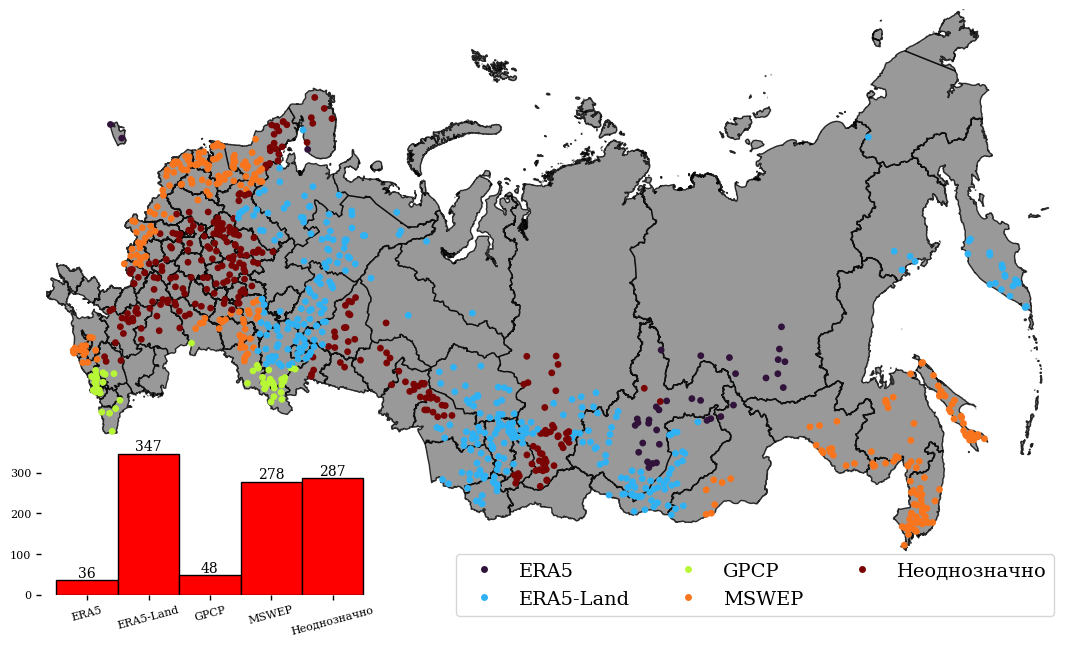

In [153]:
lstm_geom_nse_type = deepcopy(lstm_geom_nse)

model_dict = {
    "MSWEP": 1.0,
    "ERA5-Land": 2.0,
    "ERA5": 3.0,
    "GPCP": 4.0,
    "Неоднозначно": 5.0,
    np.nan: np.nan,
}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse_type.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая метео модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.33:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"

        # basin_districts.loc[i, ["Лучшая метео модель"]] = ugms_part["Лучшая метео модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая метео модель"]] = model_dict[
        #     ugms_part["Лучшая метео модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая метео модель"]] = model_dict[cool_model]
        lstm_geom_nse_type.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]],
            ["Лучшая метео модель"],
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая метео модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая метео модель"]] = np.nan
# lstm_geom_nse_type["Лучшая метео модель"] = [model_dict[i] for i in lstm_geom_nse_type["Лучшая метео модель"]]

gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse_type,
    basemap_data=basemap_data,
    distinction_col="Лучшая метео модель",
    cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=3,
    with_histogram=True,
)


In [154]:
basin_districts["Лучшая метео модель"] = [
    {k: v for v, k in model_dict.items()}[i] if not np.isnan(i) else np.nan
    for i in basin_districts["Лучшая метео модель"]
]
basin_districts[["name1", "Лучшая метео модель"]].dropna().to_csv(
    "/app/data/dw_tables/best_model_33.csv"
)


In [155]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["Best Meteo NSE"]] = ugms_part[["Best Meteo NSE"]].median()
    basin_districts.loc[i, ["Количество точек"]] = int(len(ugms_part))

basin_districts.loc[[26, 27], ["Best Meteo NSE"]] = np.nan


In [157]:
basin_to_excel = basin_districts.drop(
    columns=[
        "path",
        "geometry",
        "NSE LSTM региональная",
        "Лучшая метео модель",
        "layer",
        "NSE LSTM MSWEP",
        "NSE LSTM ERA5",
        "NSE LSTM ERA5-Land",
        "NSE LSTM GPCP",
    ]
).dropna()

basin_to_excel = basin_to_excel.set_index("name1")
basin_to_excel.index.name = "Бассейновый округ"
basin_to_excel = basin_to_excel.loc[
    :,
    [
        "Best Meteo NSE",
        "NSE Случайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM по постам",
        "Количество точек",
    ],
]
# basin_to_excel.to_excel("/app/conclusions/tables/nse_bys")
# apply some formatting for all numbers (optional)
df_s = basin_to_excel.style.format("{:.2f}")
# df_s = df_s.loc[:, ["Количество точек"]].style.format("{:.0f}")
# loop through rows and find which column for each row has the highest value
for row in basin_to_excel.index:
    col = basin_to_excel.loc[
        row,
        [
            "Best Meteo NSE",
            "NSE Случайный лес",
            "NSE GR4J",
            "NSE LSTM без физ. гео.",
            "NSE HBV",
            "NSE LSTM по постам",
        ],
    ].idxmax()
    # redo formatting for a specific cell
    # df_s = df_s.format(lambda x: "\\textbf{" + f"{x:.3f}" + "}", subset=(row, col))
df_s.to_excel("/app/data/dw_tables/NSE_by_basin_district.xlsx")


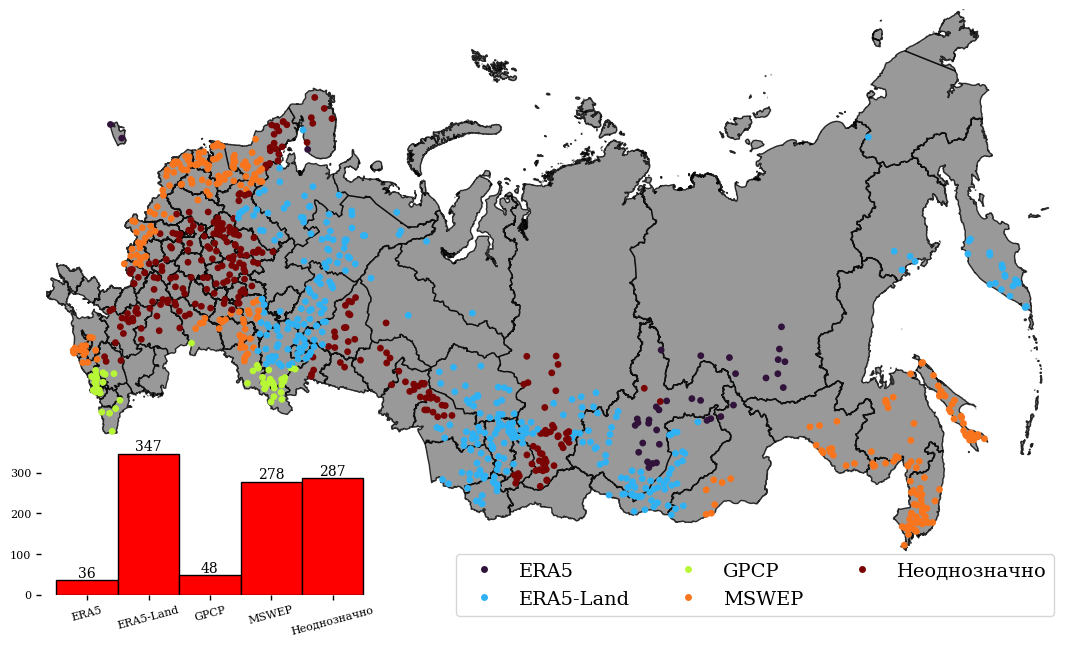

In [159]:
lstm_geom_nse_type = deepcopy(lstm_geom_nse)

model_dict = {"MSWEP": 1, "ERA5-Land": 2, "ERA5": 3, "GPCP": 4, "Неоднозначно": 5, np.nan: np.nan}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse_type.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая метео модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.33:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"

        # basin_districts.loc[i, ["Лучшая метео модель"]] = ugms_part["Лучшая метео модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая метео модель"]] = model_dict[
        #     ugms_part["Лучшая метео модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая метео модель"]] = model_dict[cool_model]
        lstm_geom_nse_type.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]],
            ["Лучшая метео модель"],
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая метео модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая метео модель"]] = np.nan
# lstm_geom_nse_type["Лучшая метео модель"] = [model_dict[i] for i in lstm_geom_nse_type["Лучшая метео модель"]]

gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse_type,
    basemap_data=basemap_data,
    distinction_col="Лучшая метео модель",
    cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=3,
    with_histogram=True,
)


In [160]:
lstm_best_table = pd.concat(
    [
        lstm_mswep_table.loc[mswep_index, :],
        lstm_era5_land_table.loc[era5_land_index, :],
        lstm_era5_table.loc[era5_index, :],
        lstm_gpcp_table.loc[gpcp_index, :],
    ]
)

lstm_s_meteo = pd.concat(
    [
        lstm_mswep_table.median().to_frame().T,
        lstm_era5_table.median().to_frame().T,
        lstm_era5_land_table.median().to_frame().T,
        lstm_gpcp_table.median().to_frame().T,
        lstm_best_table.median().to_frame().T,
    ]
)

lstm_s_meteo.index = pd.Index(["LSTM MSWEP", "LSTM ERA5", "LSTM ERA5-Land", "LSTM GPCP", "Лучшие LSTM"])

lstm_s_meteo.to_excel("/app/data/dw_tables/lstm_s_meteo_statistics.xlsx", float_format="%.2f")

### HBV, GR4J, LSTM-regional, LSTM-single, LSTM-vanila, Random Forest

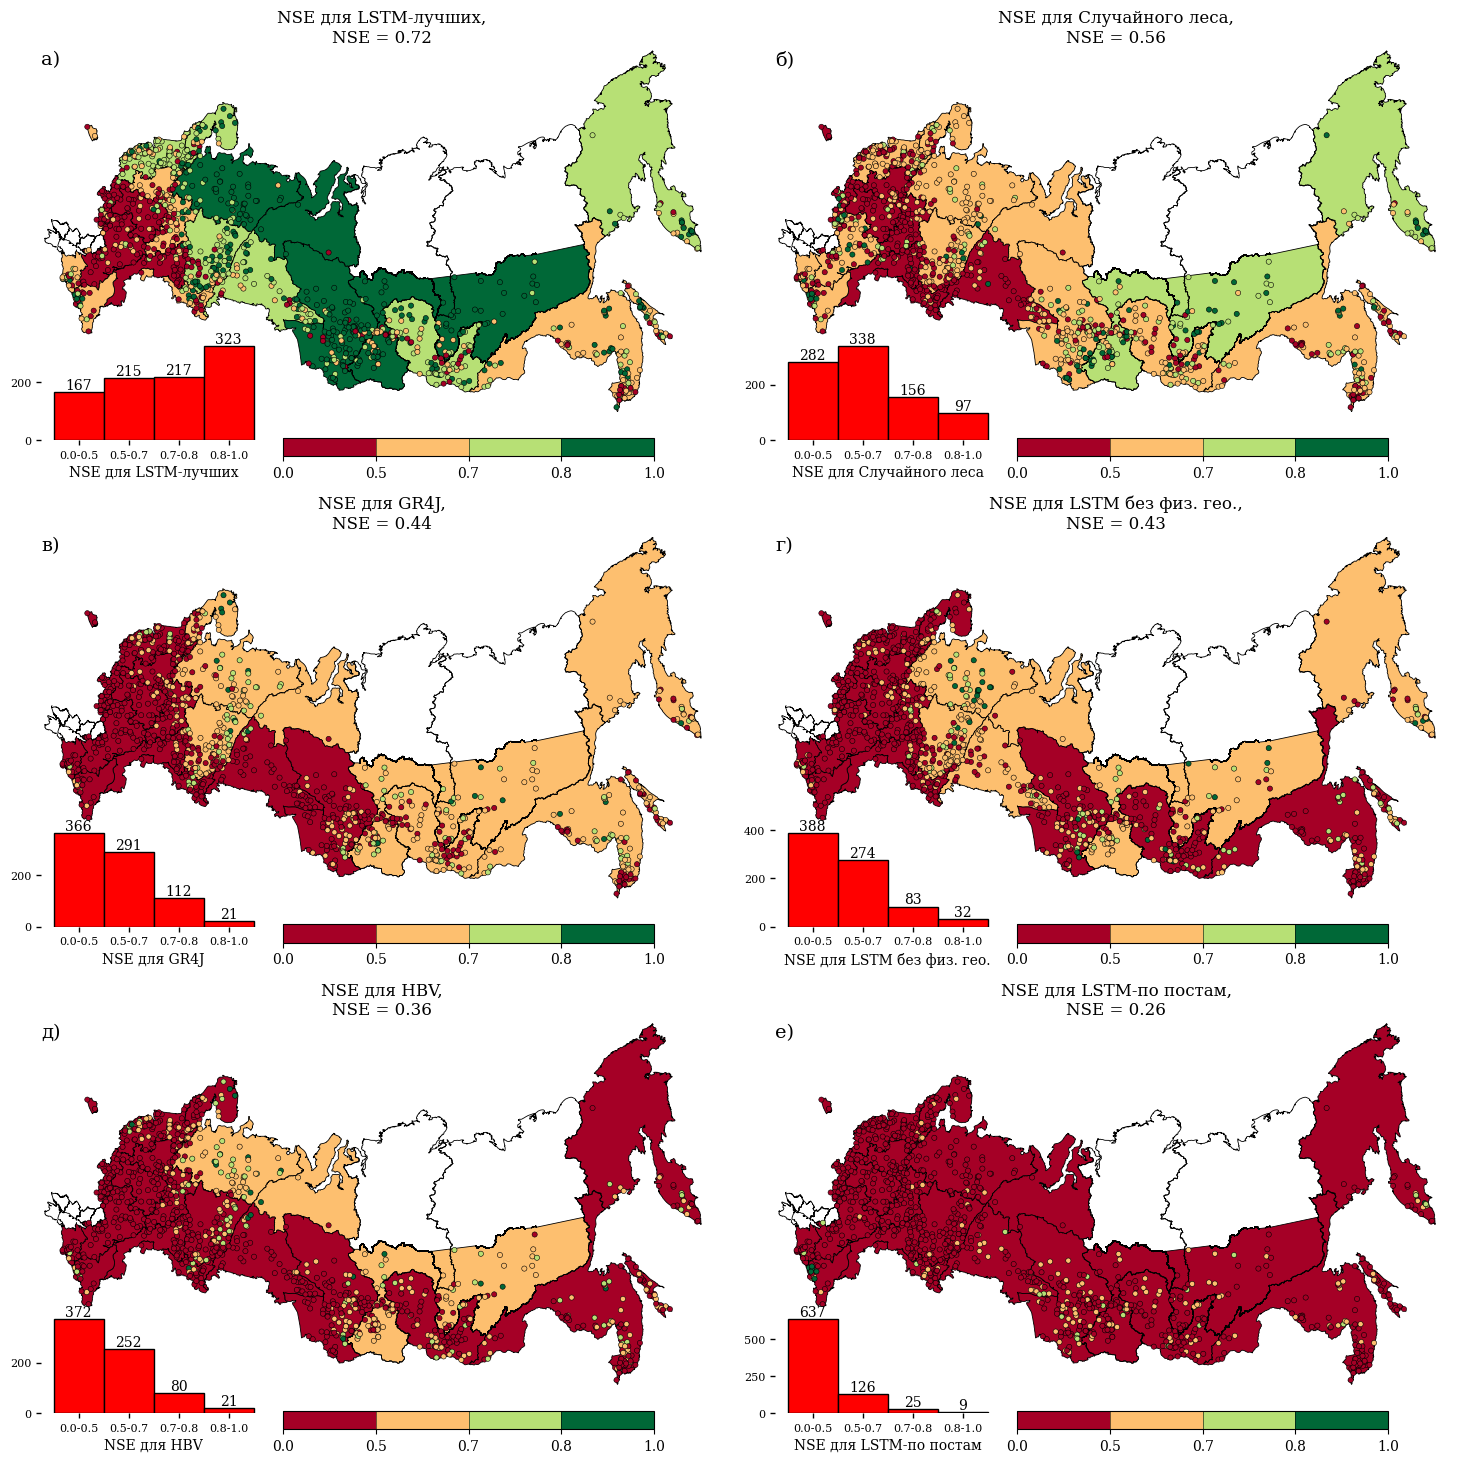

In [161]:
# lstm_geom_nse = gauges_file.loc[common_index, ["geometry"]]
lstm_best_nse = lstm_best_table.loc[common_index, "NSE"].median()

lstm_geom_nse.loc[
    :,
    [
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
    ],
] = pd.concat(
    [
        lstm_best_table.loc[common_index, "NSE"],
        rfr_table.loc[common_index, "NSE"],
        gr4j_table.loc[common_index, "NSE"],
        lstm_vanila_table.loc[common_index, "NSE"],
        hbv_table.loc[common_index, "NSE"],
        lstm_single_table.loc[common_index, "NSE"],
    ],
    axis=1,
).values

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[
        i,
        [
            "NSE LSTM-лучшие",
            "NSE Cлучайный лес",
            "NSE GR4J",
            "NSE LSTM без физ. гео.",
            "NSE HBV",
            "NSE LSTM-по постам",
        ],
    ] = ugms_part[
        [
            "NSE LSTM-лучшие",
            "NSE Cлучайный лес",
            "NSE GR4J",
            "NSE LSTM без физ. гео.",
            "NSE HBV",
            "NSE LSTM-по постам",
        ]
    ].median()

basin_districts.loc[
    [26, 27],
    [
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
    ],
] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(20, 15),
    nrows=3,
    ncols=2,
    label_list=["а)", "б)", "в)", "г)", "д)", "е)"],
    columns_from_gdf=[
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
    ],
    hist_name=[
        "NSE для LSTM-лучших",
        "NSE для Cлучайного леса",
        "NSE для GR4J",
        "NSE для LSTM без физ. гео.",
        "NSE для HBV",
        "NSE для LSTM-по постам",
    ],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM-лучших,\nNSE = {lstm_best_nse:.2f}",
        f"NSE для Cлучайного леса,\nNSE = {rfr_nse:.2f}",
        f"NSE для GR4J,\nNSE = {nse_gr4j:.2f}",
        f"NSE для LSTM без физ. гео.,\nNSE = {lstm_vanila_nse:.2f}",
        f"NSE для HBV,\nNSE = {nse_hbv:.2f}",
        f"NSE для LSTM-по постам,\nNSE = {lstm_single_nse:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


### Best 4, Worst 4

In [ ]:
best_4 = lstm_best_table[lstm_best_table["NSE"] > 0.85].sample(n=8)

mswep_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p"
)
gpcp_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p"
)
era5l_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p"
)
era5_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p"
)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

date_form = DateFormatter("%m-%y")

for gauge_id, ax in zip(best_4.index, np.ravel(axs)):
    if gauge_id in mswep_index:
        pickle_file = mswep_pickle
    elif gauge_id in gpcp_index:
        pickle_file = gpcp_pickle
    elif gauge_id in era5_index:
        pickle_file = era5_pickle
    else:
        pickle_file = era5l_pickle

    df_res = pd.read_pickle(pickle_file)[f"{gauge_id}"]["1D"]["xr"]

    draw_df = pd.DataFrame()
    obs, pred = (
        df_res["q_mm_day_obs"].to_numpy().squeeze()[:-1],
        df_res["q_mm_day_sim"].to_numpy().squeeze()[:-1],
    )

    draw_df.index = df_res.date[:-1]
    draw_df["Наблюдения, мм/день"] = obs
    draw_df["Модель, мм/день"] = pred

    draw_df.plot(
        ax=ax,
        title=f"{gauges_file.loc[gauge_id, 'name_ru']}, NSE = {best_4.loc[gauge_id, 'NSE']:.2f}, Площадь {gauges_file.loc[gauge_id, 'new_area']:.0f} $км^2$",
        fontsize=14,
    )
    ax.title.set_size(14)
    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel("Слой стока, мм/день", fontdict={"size": 14})
    ax.set_xlabel("Дата", fontdict={"size": 14})

plt.tight_layout()


In [ ]:
worst_4 = lstm_best_table[lstm_best_table["NSE"] < 0.5].sample(n=8)

mswep_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p"
)
gpcp_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p"
)
era5l_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p"
)
era5_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p"
)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

date_form = DateFormatter("%m-%y")

for gauge_id, ax in zip(worst_4.index, np.ravel(axs)):
    if gauge_id in mswep_index:
        pickle_file = mswep_pickle
    elif gauge_id in gpcp_index:
        pickle_file = gpcp_pickle
    elif gauge_id in era5_index:
        pickle_file = era5_pickle
    else:
        pickle_file = era5l_pickle

    df_res = pd.read_pickle(pickle_file)[f"{gauge_id}"]["1D"]["xr"]

    draw_df = pd.DataFrame()
    obs, pred = (
        df_res["q_mm_day_obs"].to_numpy().squeeze()[:-1],
        df_res["q_mm_day_sim"].to_numpy().squeeze()[:-1],
    )

    draw_df.index = df_res.date[:-1]
    draw_df["Наблюдения, мм/день"] = obs
    draw_df["Модель, мм/день"] = pred

    draw_df.plot(
        ax=ax,
        title=f"{gauges_file.loc[gauge_id, 'name_ru']}, NSE = {worst_4.loc[gauge_id, 'NSE']:.2f}, Площадь {gauges_file.loc[gauge_id, 'new_area']:.0f} $км^2$",
        fontsize=14,
    )
    ax.title.set_size(14)
    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel("Слой стока, мм/день", fontdict={"size": 14})
    ax.set_xlabel("Дата", fontdict={"size": 14})

plt.tight_layout()


In [ ]:
hydrograph_gauges = gauges_file.loc[common_index, ["geometry"]]

hydrograph_gauges.loc[best_4.index, "Гидрографы для"] = "Постов с NSE > 0.85"
hydrograph_gauges.loc[worst_4.index, "Гидрографы для"] = "Постов с NSE > 0.50"

hydrograph_gauges = hydrograph_gauges.dropna()

gauges_fig = russia_plots(
    gdf_to_plot=hydrograph_gauges,
    basemap_data=basemap_data,
    distinction_col="Гидрографы для",
    cmap_name="turbo",
    list_of_limits=list(range(1, 3)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=4,
    with_histogram=False,
)


### Best model from each type for each gauge

In [163]:
mswep_index = lstm_geom_nse[lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM MSWEP"])].index
era5_index = lstm_geom_nse[lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM ERA5"])].index
era5_land_index = lstm_geom_nse[
    lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM ERA5-Land"])
].index
gpcp_index = lstm_geom_nse[lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM GPCP"])].index

for name, index in {
    "MSWEP": mswep_index,
    "ERA5": era5_index,
    "ERA5-Land": era5_land_index,
    "GPCP": gpcp_index,
}.items():
    lstm_geom_nse.loc[index, "Лучшая метео модель"] = name


In [164]:
# lstm_geom_nse = gauges_file.loc[common_index, ["geometry"]]
table_dict = {
    "HBV": hbv_table.loc[common_index, :],
    "GR4J": gr4j_table.loc[common_index, :],
    "Случайный лес": rfr_table.loc[common_index, :],
    "LSTM-по постам": lstm_single_table.loc[common_index, :],
    "LSTM без физ.гео.": lstm_vanila_table.loc[common_index, :],
    "LSTM региональная": lstm_best_table.loc[common_index, :],
}

best_nse_from_each_model = list()
for model, table in table_dict.items():
    model_table = table.rename(columns={"NSE": f"NSE {model}"})
    best_nse_from_each_model.append(model_table.loc[:, [f"NSE {model}"]])

best_nse_from_each_model = pd.concat(best_nse_from_each_model, axis=1)
lstm_geom_nse["Best Model NSE"] = best_nse_from_each_model.max(axis=1)

hbv_index = lstm_geom_nse[
    lstm_geom_nse["Best Model NSE"].isin(best_nse_from_each_model["NSE HBV"])
].index
best_hbv = hbv_table.loc[hbv_index, :]


gr4j_index = lstm_geom_nse[
    lstm_geom_nse["Best Model NSE"].isin(best_nse_from_each_model["NSE GR4J"])
].index
best_gr4j = gr4j_table.loc[gr4j_index, :]

rfr_index = lstm_geom_nse[
    lstm_geom_nse["Best Model NSE"].isin(best_nse_from_each_model["NSE Случайный лес"])
].index
best_rfr = rfr_table.loc[rfr_index, :]

lstm_by_gauge_index = lstm_geom_nse[
    lstm_geom_nse["Best Model NSE"].isin(best_nse_from_each_model["NSE LSTM-по постам"])
].index
best_by_gauge = lstm_single.loc[lstm_by_gauge_index, :]

lstm_no_phys_geo_index = lstm_geom_nse[
    lstm_geom_nse["Best Model NSE"].isin(best_nse_from_each_model["NSE LSTM без физ.гео."])
].index
best_no_phys = lstm_no_static.loc[lstm_no_phys_geo_index, :]

lstm_best_index = lstm_geom_nse[
    lstm_geom_nse["Best Model NSE"].isin(best_nse_from_each_model["NSE LSTM региональная"])
].index
best_lstm = pd.concat(
    [
        lstm_mswep_table.loc[mswep_index, :],
        lstm_era5_table.loc[era5_index, :],
        lstm_era5_land_table.loc[era5_land_index, :],
        lstm_gpcp_table.loc[gpcp_index, :],
    ]
).loc[lstm_best_index, :]


In [167]:
best_model_stat = (
    pd.concat([best_hbv, best_gr4j, best_rfr, best_by_gauge, best_no_phys, best_lstm])
    .median()
    .to_frame()
    .T
)

best_model_stat.index = pd.Index(["Лучшие модели стока"])
best_model_stat.index.name = "Модель"

best_model_stat.to_excel("/app/data/dw_tables/best_model_stat.xlsx", float_format="%.2f")

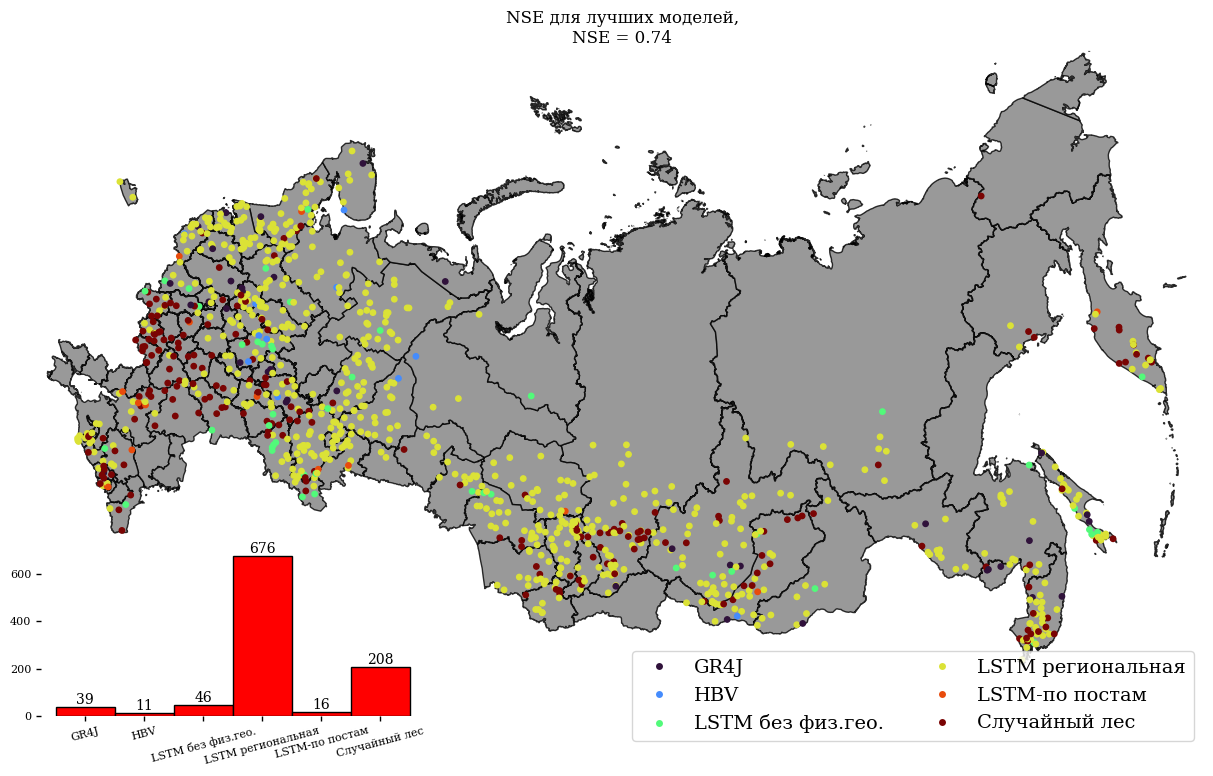

In [168]:
for name, index in {
    "HBV": hbv_index,
    "GR4J": gr4j_index,
    "Случайный лес": rfr_index,
    "LSTM-по постам": lstm_by_gauge_index,
    "LSTM без физ.гео.": lstm_no_phys_geo_index,
    "LSTM региональная": lstm_best_index,
}.items():
    lstm_geom_nse.loc[index, "Лучшая гидро модель"] = name
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["Best Model NSE"]] = ugms_part[["Best Model NSE"]].median()
    basin_districts.loc[i, ["Best Meteo NSE"]] = ugms_part[["Best Meteo NSE"]].median()
    lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], "Бассейновый округ"
    ] = ugms_name

basin_districts.loc[[26, 27], ["Best Meteo NSE"]] = np.nan
basin_districts.loc[[26, 27], ["Best Model NSE"]] = np.nan
gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    distinction_col="Лучшая гидро модель",
    cmap_name="turbo",
    # list_of_limits=list(range(0, 6)),
    title_text=f"NSE для лучших моделей,\nNSE = {lstm_geom_nse['Best Model NSE'].median():.2f}",
    figsize=(15, 10),
    just_points=True,
    legend_cols=2,
    with_histogram=True,
)


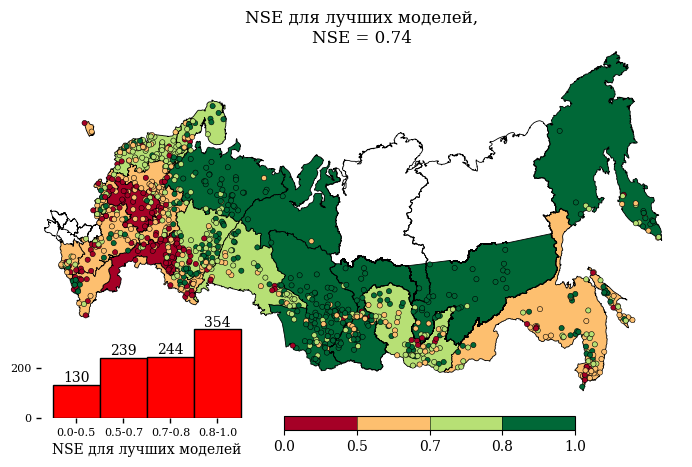

In [55]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["Best Model NSE"]] = ugms_part[["Best Model NSE"]].median()

basin_districts.loc[[26, 27], ["Best Model NSE"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=[
        "Best Model NSE",
    ],
    hist_name=["NSE для лучших моделей"],
    with_histogram=True,
    title_text=[
        f"NSE для лучших моделей,\nNSE = {lstm_geom_nse['Best Model NSE'].median():.2f}",
        f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['Best Meteo NSE'].median():.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [69]:
hydro_model_table = pd.concat(
    [
        hbv_table.loc[common_index, :].median().to_frame().T,
        gr4j_table.loc[common_index, :].median().to_frame().T,
        rfr_table.loc[common_index, :].median().to_frame().T,
        lstm_single_table.loc[common_index, :].median().to_frame().T,
        lstm_vanila_table.loc[common_index, :].median().to_frame().T,
        lstm_best_table.loc[common_index, :].median().to_frame().T,
    ]
)
hydro_model_table

NSE       KGE         r     alpha      beta      RMSE      delta
0  0.357778  0.344206  0.709393  1.200966  1.304887  0.604140  26.675534
0  0.443085  0.459946  0.733627  1.219051  1.036671  0.558919 -32.811098
0  0.559061  0.659988  0.789579  1.042802  0.979286  0.559982 -23.696445
0  0.255493  0.110941  0.611435  1.687650  1.034740  0.651856 -42.235350
0  0.426738  0.378419  0.752681  1.353148  1.111073  0.616275 -18.234477
0  0.721158  0.681662  0.883332  1.146357  1.034411  0.377659 -14.164371

In [103]:
pd.concat(
    [
        hbv_table.loc[hbv_index, :].median().to_frame().T,
        gr4j_table.loc[gr4j_index, :].median().to_frame().T,
        rfr_table.loc[rfr_index, :].median().to_frame().T,
        lstm_single_table.loc[lstm_by_gauge_index, :].median().to_frame().T,
        lstm_vanila_table.loc[lstm_no_phys_geo_index, :].median().to_frame().T,
        lstm_best_table.loc[lstm_best_index, :].median().to_frame().T,
    ]
)

NSE       KGE         r     alpha      beta      RMSE      delta
0  0.668282  0.708480  0.863202  1.181329  1.074758  0.416571   6.212686
0  0.600167  0.576617  0.819416  1.318886  1.025443  0.572507 -44.861588
0  0.683931  0.737925  0.853265  1.041136  0.957292  0.311509 -20.828199
0  0.424312 -0.143921  0.692257  1.957762  1.022717  0.162468 -17.578793
0  0.589756  0.568417  0.817760  1.189555  0.974354  0.335004 -36.954951
0  0.779652  0.725161  0.906024  1.153821  1.032354  0.404046 -14.534233

In [63]:
basin_districts.loc[:, ["name1", "Best Model NSE"]].dropna().to_csv(
    "/app/data/dw_tables/bo_lstm_best_model.csv", index=False
)
lstm_regional_table_stat = pd.concat([lstm_regional_table.median().to_frame().T])
lstm_regional_table_stat.index = pd.Index(["Лучшая модель стока"])
lstm_regional_table_stat.index.name = "Модель"
lstm_regional_table_stat.to_excel(
    "/app/data/dw_tables/models_regional_statistics.xlsx", float_format="%.2f"
)
lstm_regional_table_stat

AttributeError: 'float' object has no attribute 'to_frame'

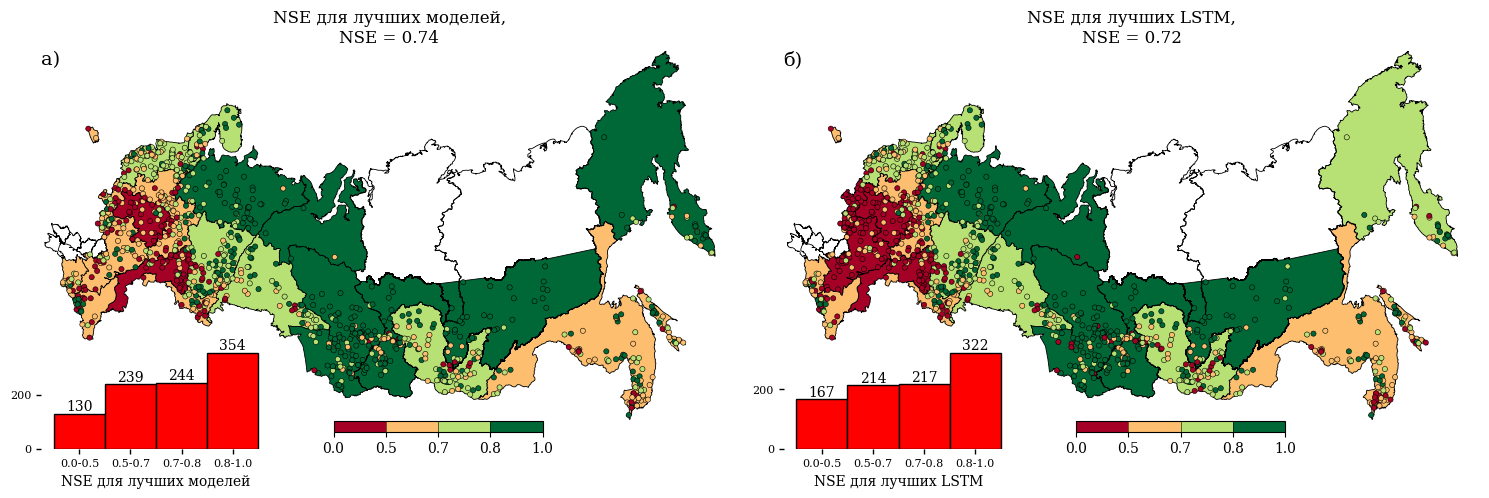

In [43]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["Best Model NSE"]] = ugms_part[["Best Model NSE"]].median()

basin_districts.loc[[26, 27], ["Best Model NSE"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    columns_from_gdf=["Best Model NSE", "Best Meteo NSE"],
    hist_name=["NSE для лучших моделей", "NSE для лучших LSTM"],
    with_histogram=True,
    title_text=[
        f"NSE для лучших моделей,\nNSE = {lstm_geom_nse['Best Model NSE'].median():.2f}",
        f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['Best Meteo NSE'].median():.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [45]:
lstm_geom_nse.drop("geometry", axis=1).to_csv("/app/data/dw_tables/StatByGauge.csv")


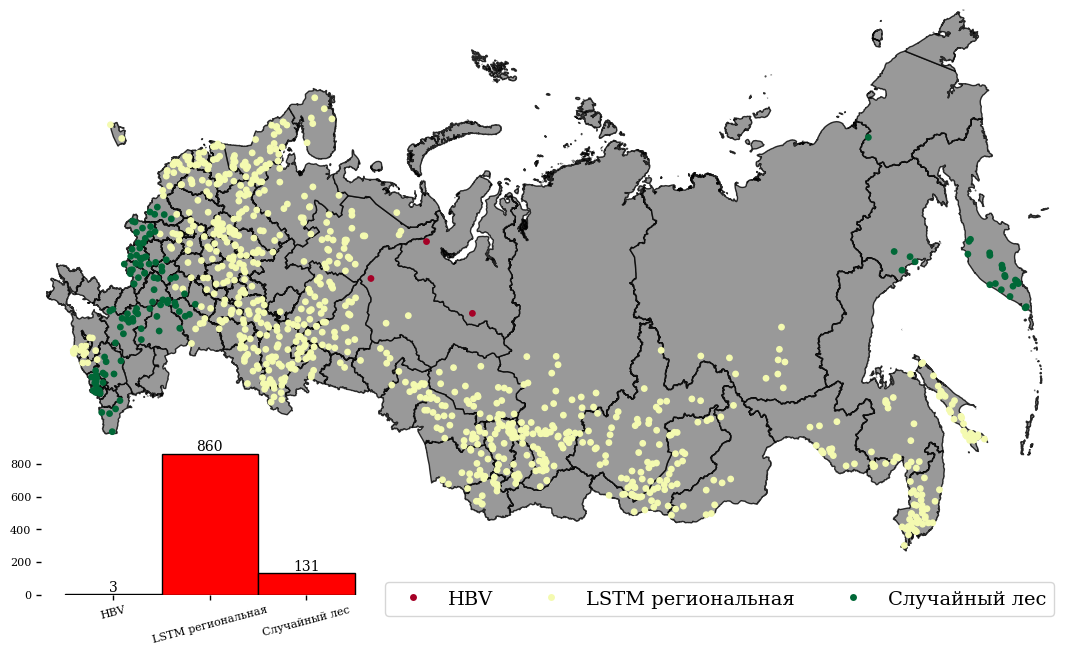

In [47]:
lstm_geom_nse_type = deepcopy(lstm_geom_nse)

model_dict = {
    "HBV": 1,
    "GR4J": 2,
    "Случайный лес": 3,
    "LSTM-по постам": 4,
    "LSTM без физ.гео.": 5,
    "LSTM региональная": 6,
    "Неоднозначно": 7,
    np.nan: np.nan,
}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse_type.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая гидро модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.33:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"

        # basin_districts.loc[i, ["Лучшая гидро модель"]] = ugms_part["Лучшая гидро модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая гидро модель"]] = model_dict[
        #     ugms_part["Лучшая гидро модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая гидро модель"]] = model_dict[cool_model]
        lstm_geom_nse_type.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]],
            ["Лучшая гидро модель"],
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая гидро модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая гидро модель"]] = np.nan
# lstm_geom_nse_type["Лучшая гидро модель"] = [model_dict[i] for i in lstm_geom_nse_type["Лучшая гидро модель"]]

gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse_type,
    basemap_data=basemap_data,
    distinction_col="Лучшая гидро модель",
    # cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=3,
    with_histogram=True,
)


NSE       KGE         r     alpha      beta      RMSE  \
gauge_id                                                               
11538     0.836731  0.708658  0.924826  1.197116  1.200933  0.635056   
75236     0.539106  0.342627  0.744381  1.604598  1.035491  1.140388   
70339     0.844391  0.788413  0.922275  1.165542  1.106413  1.068744   
75607     0.665590  0.708302  0.887564  0.837801  0.785205  0.331991   
75656     0.518891  0.730956  0.826556  0.813245  0.913834  0.243334   
...            ...       ...       ...       ...       ...       ...   
74438     0.458833  0.496285  0.763222  1.372582  0.757415  0.327894   
70118     0.770001  0.342890  0.940981  1.551163  1.352887  1.099137   
72577     0.823620  0.635320  0.940694  1.303860  1.192726  0.300961   
48069     0.711289  0.753684  0.844046  1.186905  1.037637  1.143897   
7174      0.779286  0.557620  0.917854  1.365924  1.234631  1.315078   

              delta  
gauge_id             
11538     32.143240  
75236    -71.129625  
70339     -2.945966  
75607    -41.786566  
75656     15.371338  
...             ...  
74438    -71.532950  
70118      3.535722  
72577      1.790162  
48069    -43.514977  
7174      16.244050  

[994 rows x 7 columns]

In [169]:
final_table = list()


def table_statistics(table: pd.DataFrame, table_name: str):
    nse_row = pd.DataFrame()
    nse_row.loc[table_name, "Постов в исследовании"] = f"{table['NSE'].__len__():.0f}"
    nse_row.loc[table_name, "NSE медиана"] = f"{(table['NSE'].median()):.2f}"
    nse_row.loc[table_name, "NSE < 0.5"] = f"{(table['NSE'] < 0.5).sum():.0f}"
    nse_row.loc[table_name, "NSE < 0"] = f"{(table['NSE'] < 0).sum():.0f}"
    nse_row.loc[table_name, "NSE > 0.5"] = f"{((table['NSE'] > 0.5).sum()):.0f}"
    nse_row.loc[table_name, "NSE удовл., %"] = (
        f"{((table['NSE'] > 0.5).sum() / table['NSE'].__len__()):.1%}"
    )

    return nse_row


table_dict = {
    "HBV": hbv_table.loc[common_index, :],
    "GR4J": gr4j_table.loc[common_index, :],
    "Случайный лес": rfr_table.loc[common_index, :],
    "LSTM MSWEP": lstm_regional_table.loc[common_index, :],
    "LSTM-по постам": lstm_single_table.loc[common_index, :],
    "LSTM без физ.гео.": lstm_vanila_table.loc[common_index, :],
    "LSTM лучшие": lstm_best_table.loc[common_index, :],
    "Модели лучшие": pd.concat(
        [best_hbv, best_gr4j, best_rfr, best_by_gauge, best_no_phys, best_lstm]
    ).loc[common_index, :],
}

for name, table in table_dict.items():
    final_table.append(table_statistics(table=table, table_name=name))
final_table = pd.concat(final_table)
final_table = final_table.sort_values(by="NSE медиана", ascending=False)
final_table.to_excel("/app/data/dw_tables/nse_table_result.xlsx", float_format="%.2f")
final_table


Постов в исследовании NSE медиана NSE < 0.5 NSE < 0  \
Модели лучшие                       996        0.74       157      27   
LSTM лучшие                         996        0.72       241      74   
LSTM MSWEP                          996        0.64       340     121   
Случайный лес                       996        0.56       405     123   
GR4J                                996        0.44       572     206   
LSTM без физ.гео.                   996        0.43       607     219   
HBV                                 996        0.36       643     271   
LSTM-по постам                      996        0.26       836     199   

                  NSE > 0.5 NSE удовл., %  
Модели лучшие           839         84.2%  
LSTM лучшие             755         75.8%  
LSTM MSWEP              656         65.9%  
Случайный лес           591         59.3%  
GR4J                    424         42.6%  
LSTM без физ.гео.       389         39.1%  
HBV                     353         35.4%  
LSTM-по постам          160         16.1%